Custom plots related to ENSO regression focused on specific seasons and extratropical teleconnections.

In [1]:
from collections import namedtuple
from utils import get_beaker_dataset_variables
from constants import SECONDS_PER_DAY #, ENSO_DEEP_DIVE
import xarray as xr
from fme.ace.aggregator.inference.enso.historical_index import NINO34_INDEX
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.rcParams['figure.dpi'] = 300
import yaml
from typing import Mapping
xr.set_options(keep_attrs=True)

/home/OliWM/miniconda3/envs/fme/lib/python3.11/site-packages/earth2grid/healpix.py:60: UserWarning: healpixpad_cuda module not available, reverting to CPU for all padding routines
  warnings.warn("healpixpad_cuda module not available, reverting to CPU for all padding routines")


In [2]:
seasons = {"all_seasons": [1, 4, 7, 10], "DJF": [1], "JJA": [7]}

WANDB_ID_FILE = "./wandb_ids.yaml"
RUN_LENGTH = "81yr"  # either "10yr" or "81yr"

with open(WANDB_ID_FILE, "r") as f:
    wandb_ids = yaml.safe_load(f)

RUN_IDS_10YR = {
    "ACE2-ERA5": {
        "IC0": wandb_ids["era5-co2-10yr-RS2-IC0-monthly-output"],
        "IC1": wandb_ids["era5-co2-10yr-RS2-IC1-monthly-output"],
        "IC2": wandb_ids["era5-co2-10yr-RS2-IC2-monthly-output"],
    },
    "ACE2-SHiELD": {
        "IC0": wandb_ids["shield-amip-1deg-ace2-inference-10yr-IC0-monthly"],
        "IC1": wandb_ids["shield-amip-1deg-ace2-inference-10yr-IC1-monthly"],
        "IC2": wandb_ids["shield-amip-1deg-ace2-inference-10yr-IC2-monthly"],
    },
}
RUN_IDS_81YR = {
    "ACE2-ERA5": {
        "IC0": wandb_ids["era5-co2-81yr-RS2-IC0-monthly-output"],
    },
    "ACE2-SHiELD": {
        "IC0": wandb_ids["shield-amip-1deg-ace2-inference-81yr-IC0-monthly"],
    },
}

In [3]:

if RUN_LENGTH == "10yr":
    run_ids = RUN_IDS_10YR
elif RUN_LENGTH == "81yr":
    run_ids = RUN_IDS_81YR
else:
    raise ValueError(f"Invalid RUN_LENGTH: {RUN_LENGTH}. Must be '10yr' or '81yr'.")

In [4]:
EvalVar = namedtuple("EvalVar", ("name", "long_name", "units", "conversion_factor"))

EVAL_VARS = [
    EvalVar("PRATEsfc", "surface precipitation", "mm/day", SECONDS_PER_DAY),
    EvalVar("h500", "500hPa geopotential height", "m", 1.0),
    EvalVar("TMP2m", "2m air temperature", "K", 1.0),
    EvalVar("northward_wind_3", "northward wind at level 3", "m/s", 1.0),
]
DS_VARS = [var.name for var in EVAL_VARS] + ["counts"]

In [5]:
def load(runs: Mapping[str, Mapping[str, str]]) -> xr.Dataset:
    """
    Load the dataset from the given runs.
    """
    datasets = []
    for group_name, group_runs in runs.items():
        for ic_name, ic_run in group_runs.items():
            if "-" in ic_name:
                ic_name = ic_name.split("-")[1]
            full_key = '/'.join([group_name, ic_name])
            print(f"Getting dataset for run: {full_key=}")
            ic_dataset = get_beaker_dataset_variables(ic_run, 'monthly_mean_predictions.nc', DS_VARS).drop_vars("counts")
            target_dataset = get_beaker_dataset_variables(ic_run, 'monthly_mean_target.nc', DS_VARS).drop_vars("counts")
            for var in EVAL_VARS:
                if var.conversion_factor is not None:
                    ic_dataset[var.name] = var.conversion_factor * ic_dataset[var.name]
                    target_dataset[var.name] = var.conversion_factor * target_dataset[var.name]
                    ic_dataset[var.name].attrs['units'] = var.units
                    target_dataset[var.name].attrs['units'] = var.units
            common_dims = {'group': [group_name], 'IC': [ic_name]}
            datasets.append(ic_dataset.expand_dims(common_dims | {'source': ['prediction']}))
            datasets.append(target_dataset.expand_dims(common_dims | {'source': ['target']}))
    result = xr.merge(datasets).squeeze()
    result['time'] = result.valid_time
    result = result.drop_vars('valid_time')
    return result

In [6]:
monthly_ds = load(run_ids)

if RUN_LENGTH == "81yr":
    months_to_drop = 3
elif RUN_LENGTH == "10yr":
    months_to_drop = 2

# monthly data writer saves empty months at the end of the dataset
monthly_ds = monthly_ds.isel(time=slice(None, -months_to_drop))

Getting dataset for run: full_key='ACE2-ERA5/IC0'


Output()

Output()

Getting dataset for run: full_key='ACE2-SHiELD/IC0'


Output()

Output()

In [7]:
monthly_ds

<xarray.Dataset> Size: 4GB
Dimensions:           (time: 972, lat: 180, lon: 360, group: 2, source: 2)
Coordinates:
  * time              (time) datetime64[ns] 8kB 1940-01-15 ... 2020-12-15
  * lat               (lat) float32 720B -89.24 -88.25 -87.25 ... 88.25 89.24
  * lon               (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * group             (group) object 16B 'ACE2-ERA5' 'ACE2-SHiELD'
    IC                <U3 12B 'IC0'
  * source            (source) object 16B 'prediction' 'target'
    init_time         datetime64[ns] 8B 1940-01-01
Data variables:
    PRATEsfc          (group, source, time, lat, lon) float32 1GB 0.02641 ......
    h500              (group, source, time, lat, lon) float32 1GB 5.098e+03 ....
    TMP2m             (group, source, time, lat, lon) float32 1GB 241.8 ... 2...
    northward_wind_3  (group, source, time, lat, lon) float32 1GB 2.33 ... 5.058

In [8]:
if RUN_LENGTH == "10yr":
    clim_period = slice('2001', '2010')
elif RUN_LENGTH == "81yr":
    clim_period = slice('1990', '2020')
clim = monthly_ds.sel(time=clim_period).groupby('time.month').mean()

if "IC" in clim.dims:
    # also average over ensemble for estimating climatology
    clim = clim.mean(dim='IC')

In [9]:
monthly_anomaly = monthly_ds.groupby("time.month") - clim

In [10]:
seasonal_anomaly = monthly_anomaly.rolling(time=3, center=True).mean().isel(time=slice(None, None, 3))

In [11]:
nino_data = [x[1] for x in NINO34_INDEX]
nino_time = [np.datetime64(f'{x[0]}-{x[1]:02d}-15') for x, _ in NINO34_INDEX]
nino34_da = xr.DataArray(nino_data, dims=["time"], coords={"time": nino_time})

In [12]:
regression = []
for season_name, season_months in seasons.items():
    data = seasonal_anomaly.sel(time=seasonal_anomaly.time.dt.month.isin(season_months))
    nino_data = nino34_da.sel(time=data.time)
    tmp = (data * nino_data).sum(dim="time") / (nino_data**2).sum(dim="time")
    regression.append(tmp.assign_coords(season=season_name))
regression = xr.concat(regression, dim="season")
for name in regression:
    regression[name].attrs["long_name"] = monthly_ds[name].attrs["long_name"]
    regression[name].attrs["units"] = monthly_ds[name].attrs["units"] + " / K"

In [13]:
regression.to_netcdf(f"data/enso_regression_{RUN_LENGTH}.nc", mode="w", format="NETCDF4")

In [14]:
def plot_maps_ic(da, **kwargs):
    fg = da.plot(row='source', col='IC', transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)}, **kwargs)
    fg.map(lambda: plt.gca().coastlines(linewidth=0.5, color='grey'))
    fig = fg.fig
    fig.set_size_inches(11, 4)
    return fig

def plot_maps(da, **kwargs):
    fg = da.plot(row='source', col='group', transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)}, **kwargs)
    fg.map(lambda: plt.gca().coastlines(linewidth=0.5, color='grey'))
    fig = fg.fig
    fig.set_size_inches(7, 3.8)
    return fig

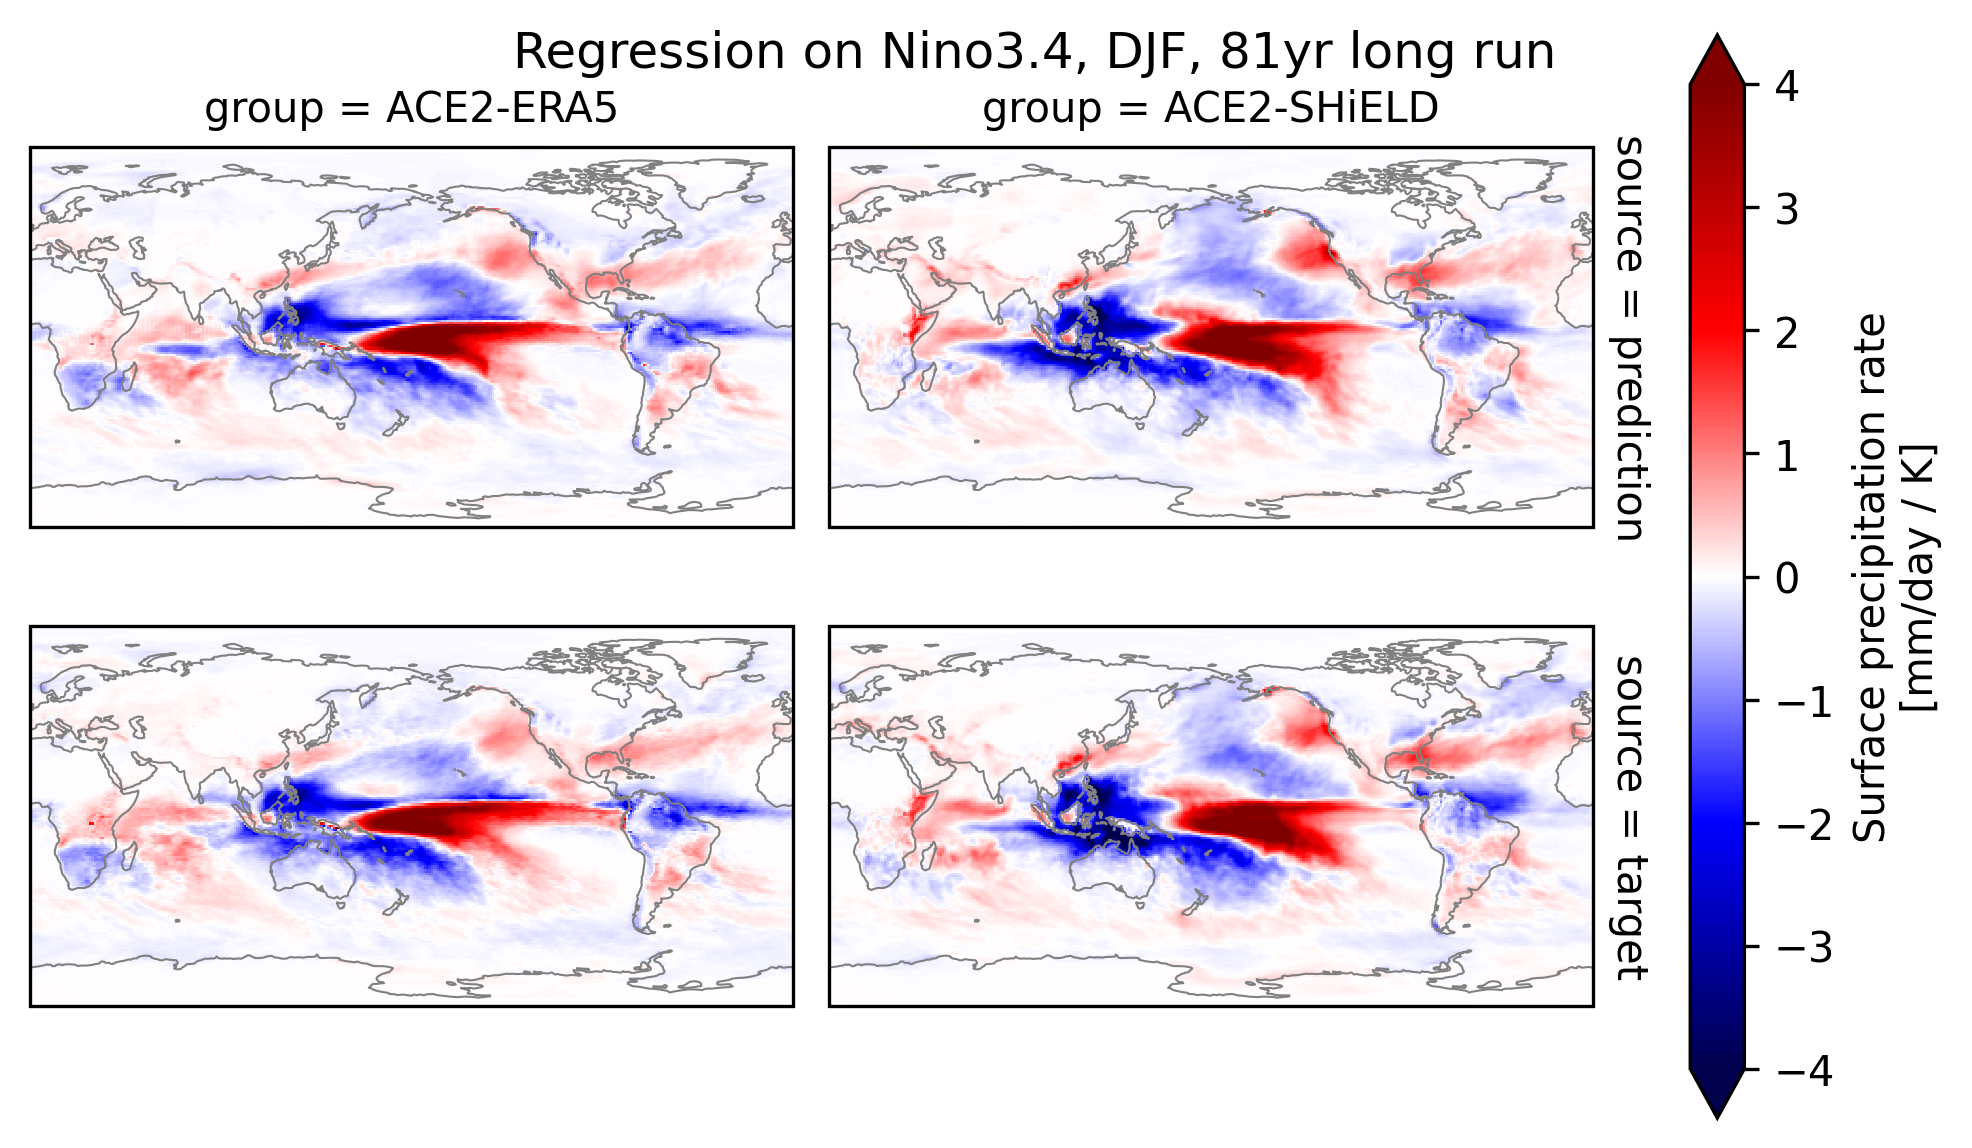

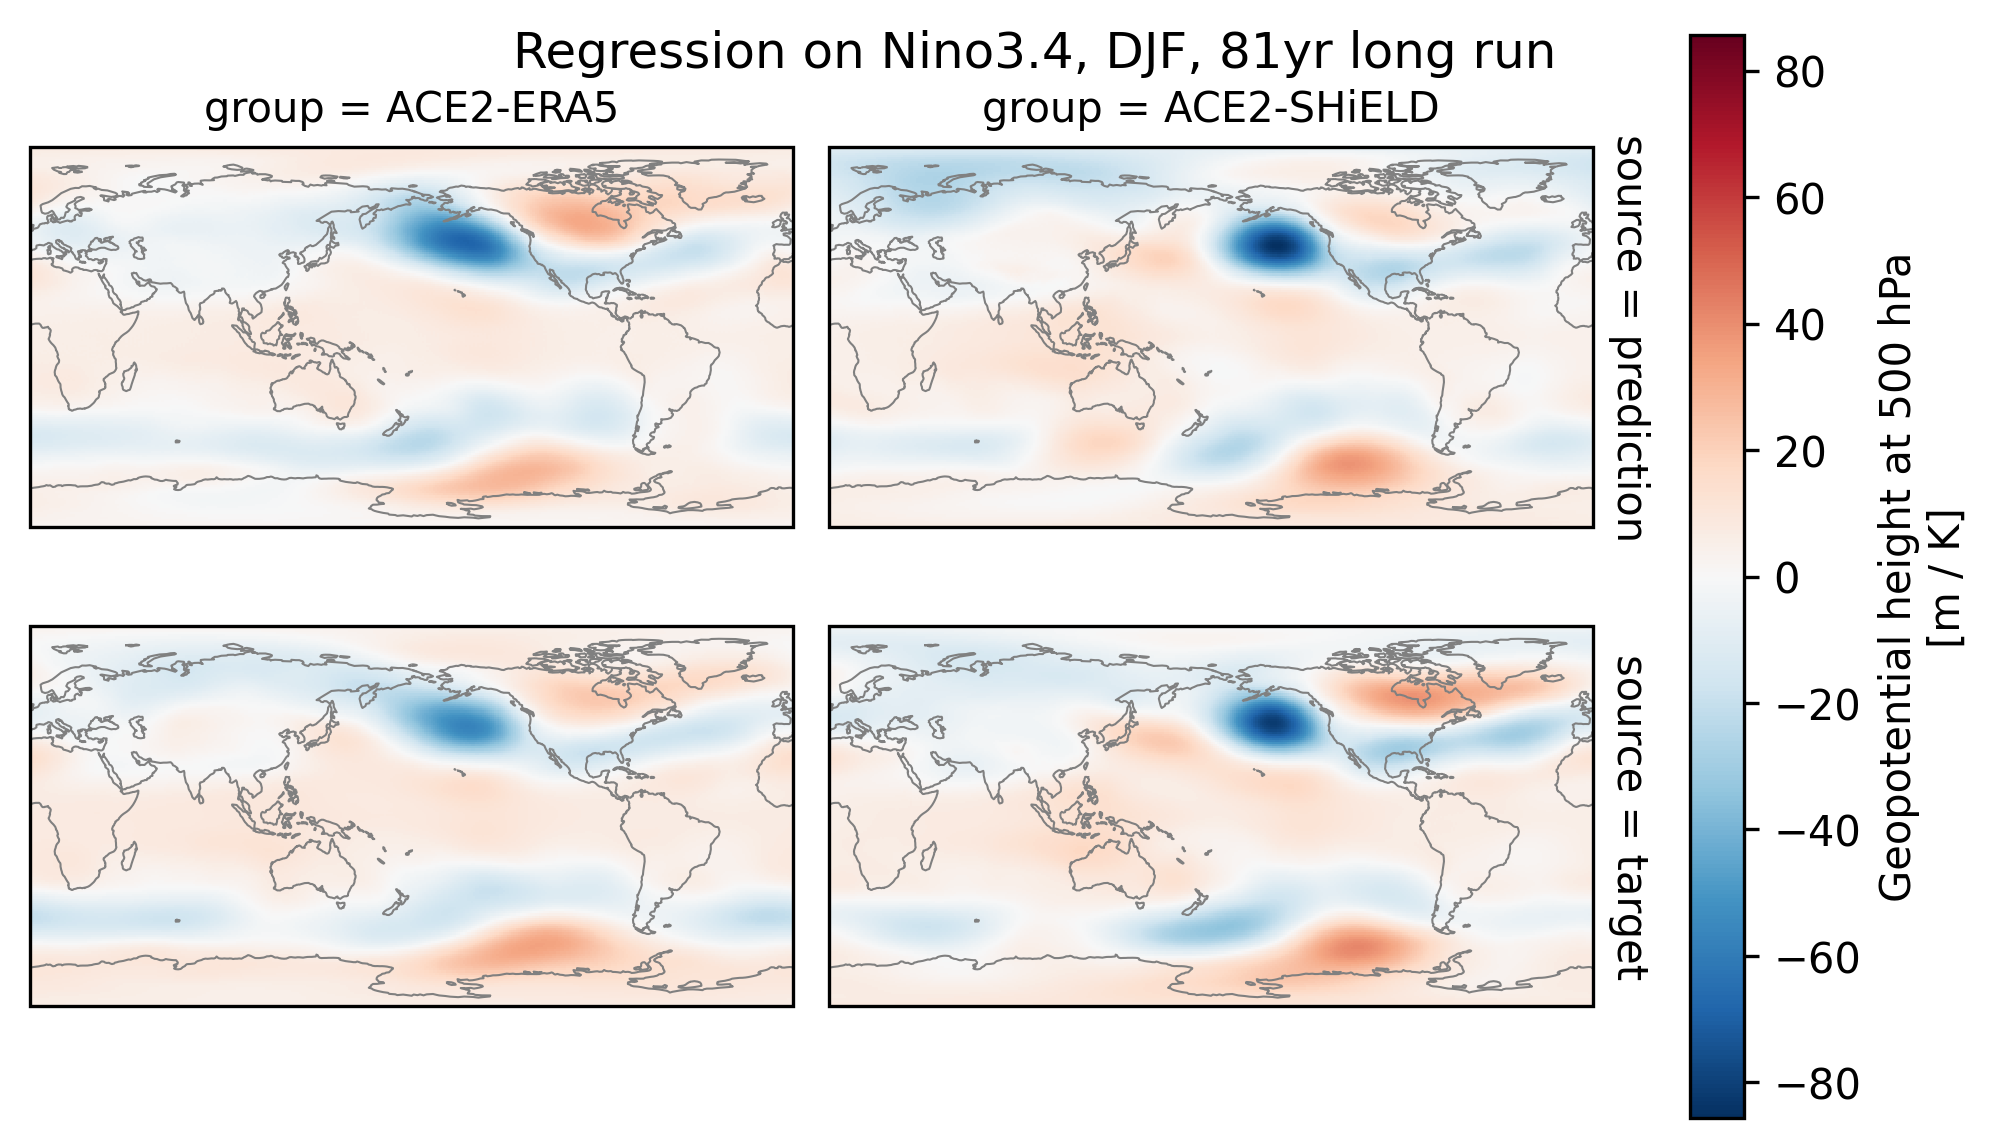

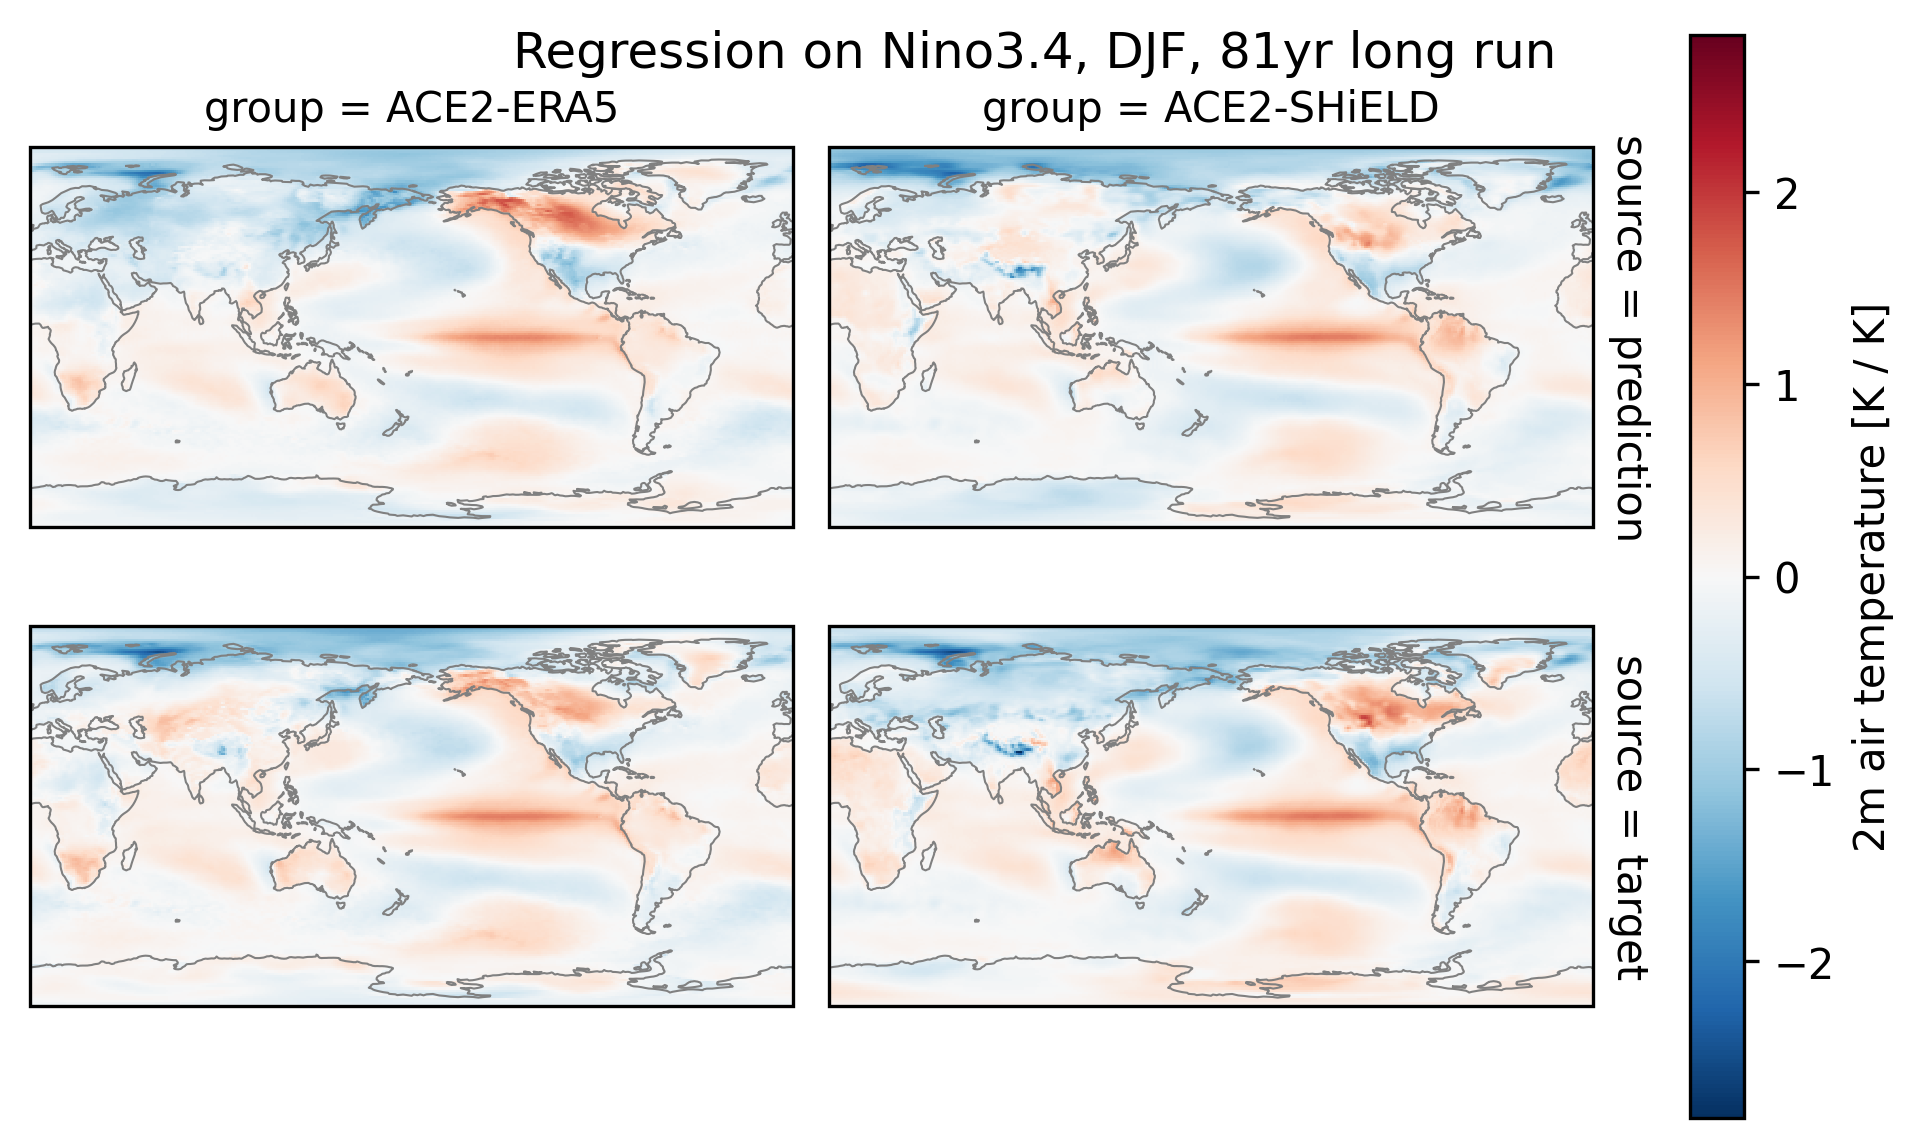

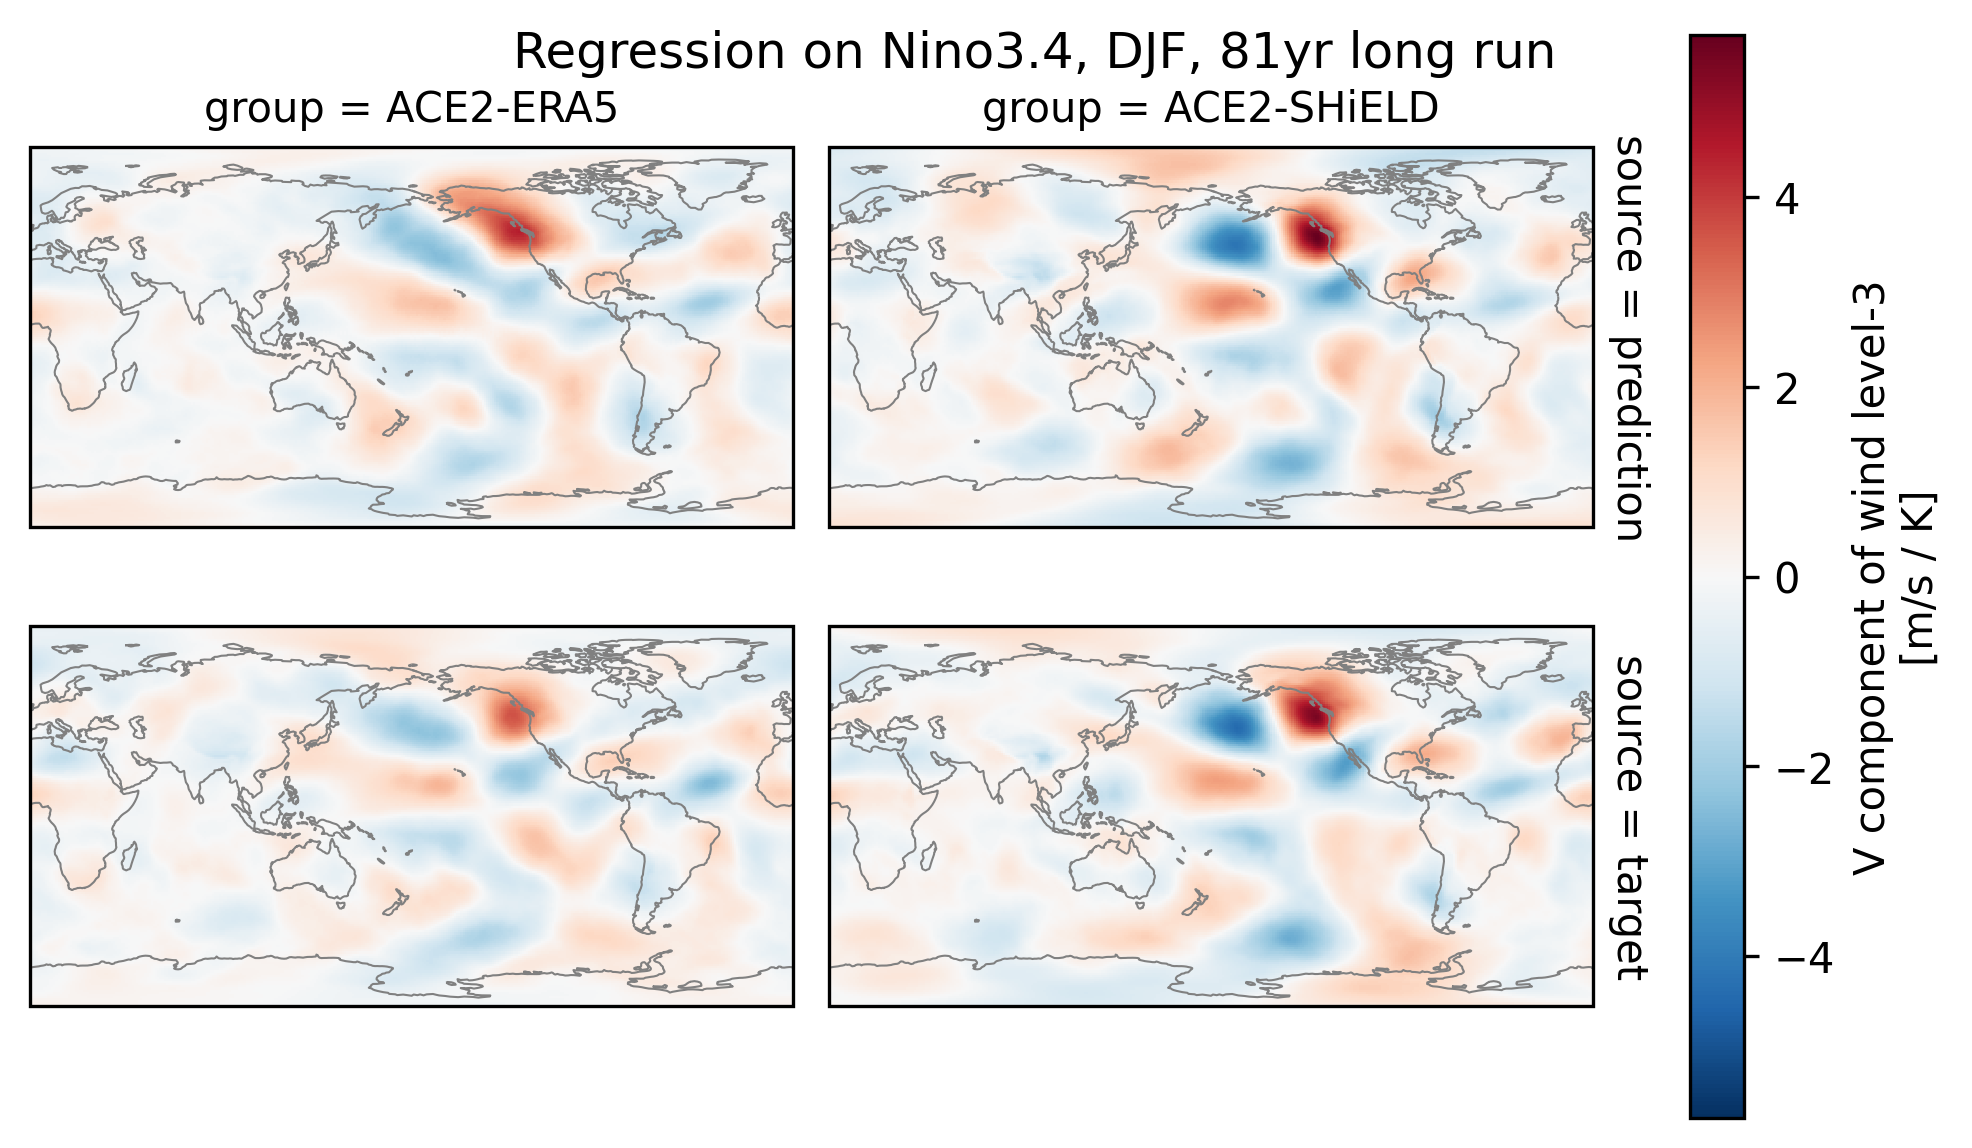

In [15]:
for var in regression.data_vars:
    if var == 'PRATEsfc':
        kwargs = {'vmin': -4, 'vmax': 4, 'cmap': 'seismic'}
    else:
        kwargs = {}
    
    for season in ['DJF']:
        plotme = regression[var].sel(season=season)
        if "IC" in plotme.dims:
            plotme = plotme.mean(dim="IC")
        fig = plot_maps(plotme, **kwargs)
        fig.suptitle(f"Regression on Nino3.4, {season}, {RUN_LENGTH} long run")
        fig.savefig(f"figures/enso_teleconnections/{RUN_LENGTH}_{var}_{season}_ensemble_mean.png", bbox_inches='tight', transparent=True)

In [16]:
# plot individual ensemble members
group = "ACE2-ERA5"
if "IC" in regression.dims:
    for var in regression.data_vars:
        if var == 'PRATEsfc':
            kwargs = {'vmin': -4, 'vmax': 4, 'cmap': 'seismic'}
        else:
            kwargs = {}
        
        for season in ['DJF']:
            plotme = regression[var].sel(season=season, group=group)
            fig = plot_maps_ic(plotme, **kwargs)
            fig.suptitle(f"{group} regression on Nino3.4, {season}, {RUN_LENGTH} long run")
            fig.savefig(f"figures/enso_teleconnections/{RUN_LENGTH}_{group}_{var}_{season}_individual_ICs.png", bbox_inches='tight', transparent=True)

## Plot final paper figures, combining 10-year and 81-year simulations
Note it is necessary to run this notebook twice with both RUN_LENGTH settins for this section to work. (Ugh... annoying but otherwise was hitting OOM when processing both runs in the same notebook).

In [17]:
regression_10yr = xr.open_dataset(f"data/enso_regression_10yr.nc").assign_coords(run_years="2001-2010")
regression_81yr = xr.open_dataset(f"data/enso_regression_81yr.nc").assign_coords(run_years="1940-2020")

In [18]:
combined = xr.concat([regression_10yr.mean("IC"), regression_81yr], dim="run_years")
to_be_plotted = combined.sel(group="ACE2-ERA5", season="DJF")
to_be_plotted['source'] = ["ACE2-ERA5", "ERA5"]

In [19]:
def plot_maps2(da, **kwargs):
    fg = da.plot(transform=ccrs.PlateCarree(), subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)}, **kwargs)
    fg.map(lambda: plt.gca().coastlines(linewidth=0.5, color='grey'))
    fig = fg.fig
    fig.set_size_inches(7, 3.8)
    fg.set_titles(template="{value}")
    return fig

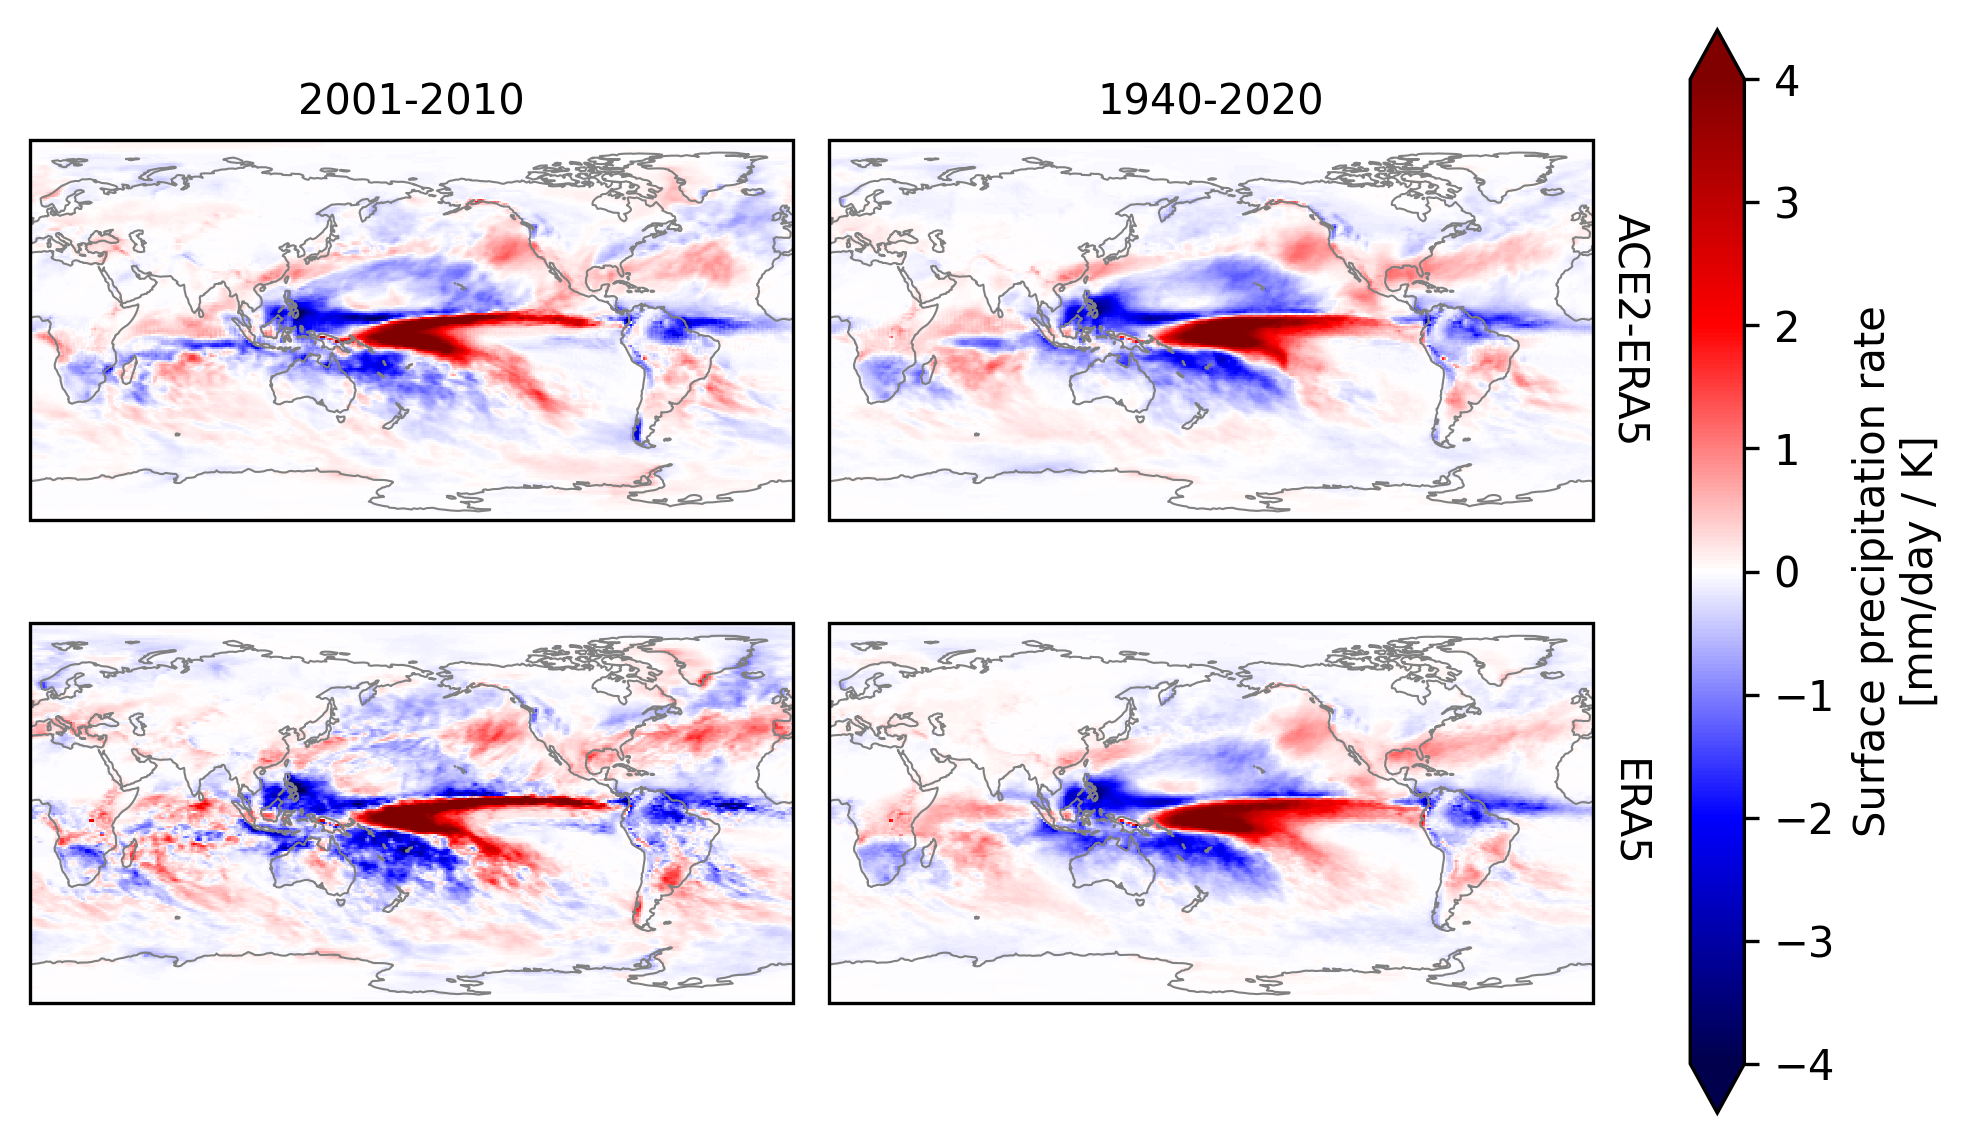

In [20]:
fig = plot_maps2(to_be_plotted.PRATEsfc, col="run_years", row="source", vmin=-4, vmax=4, cmap="seismic")
fig.savefig(f"figures/enso_regression_ERA5_DJF_10yr_81yr_PRATEsfc.png", bbox_inches='tight', transparent=True)

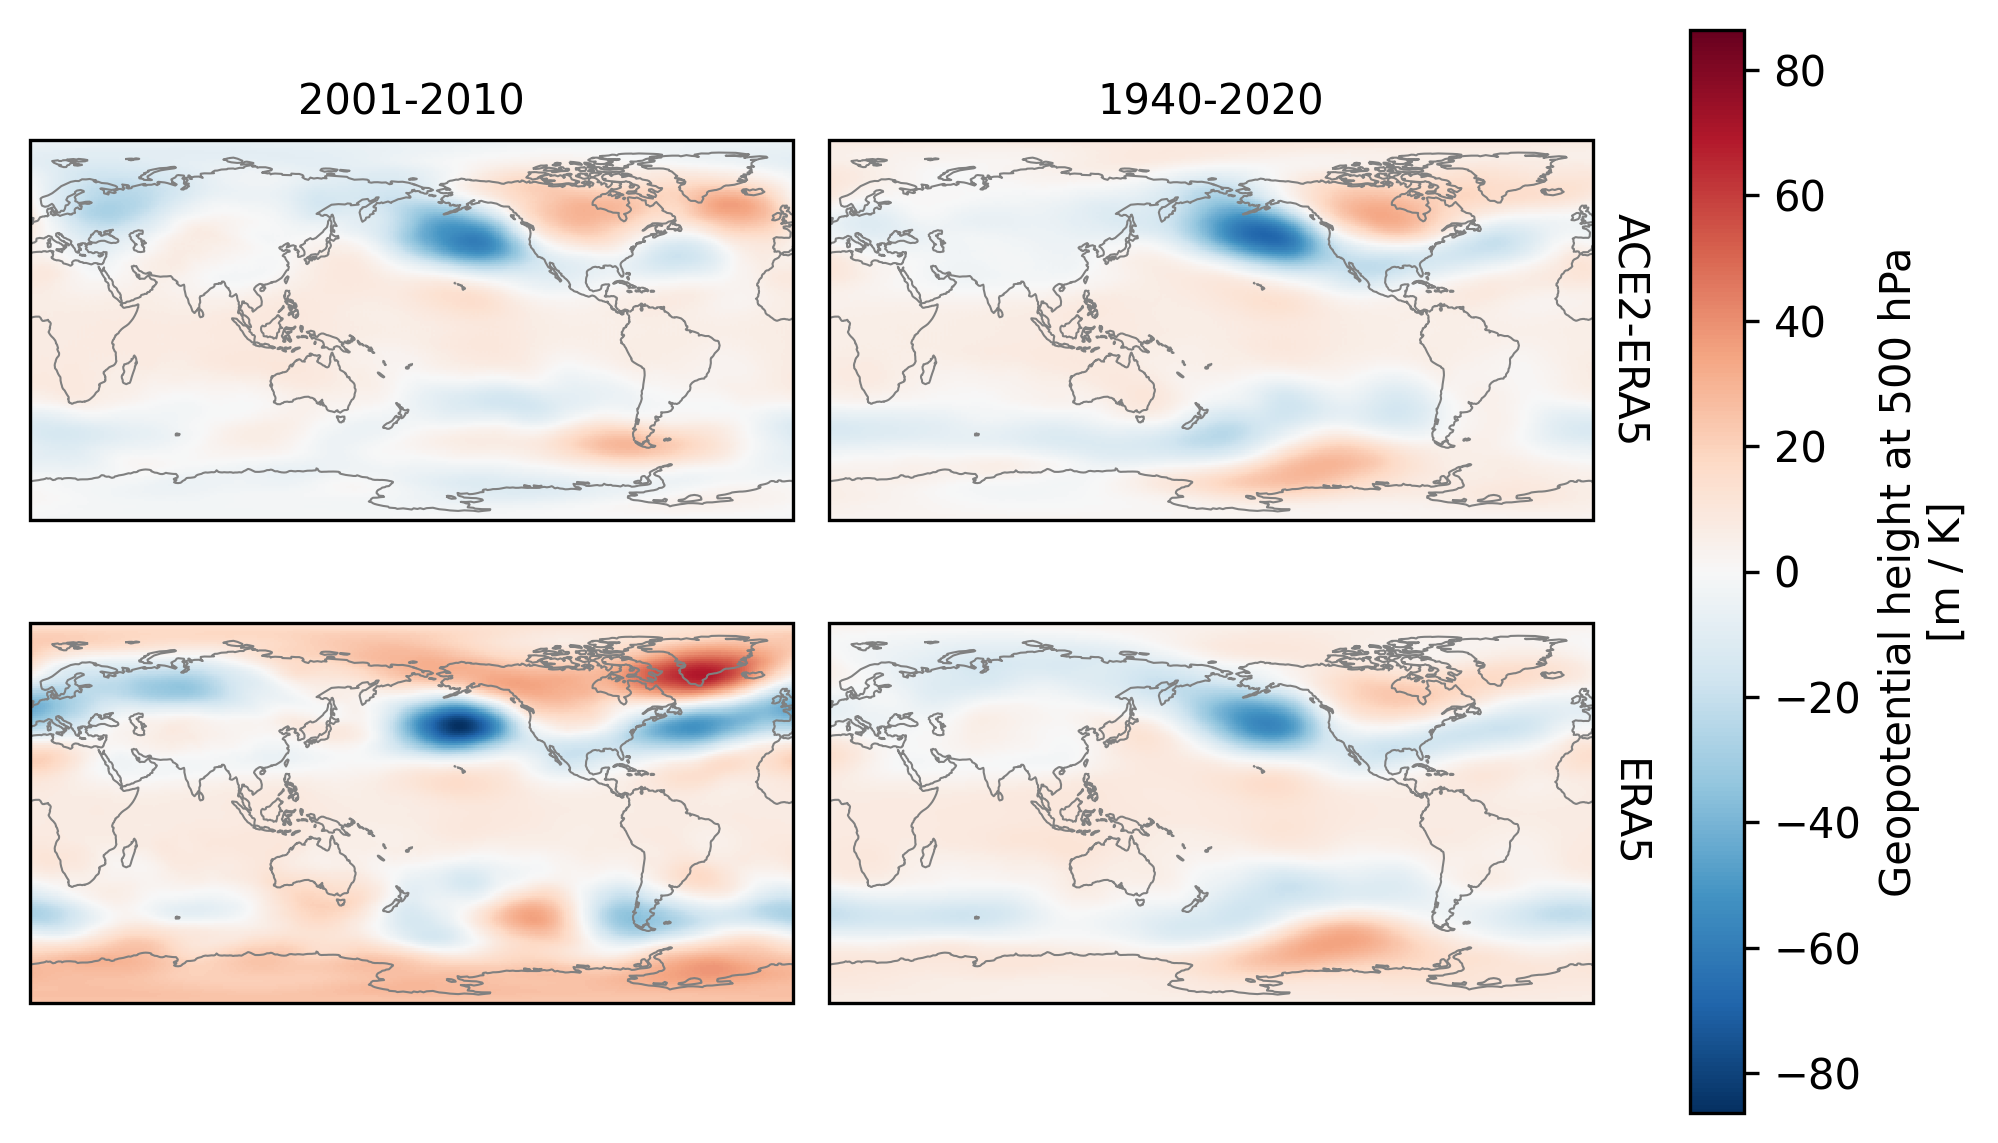

In [21]:
fig = plot_maps2(to_be_plotted.h500, col="run_years", row="source")
fig.savefig(f"figures/enso_regression_ERA5_DJF_10yr_81yr_h500.png", bbox_inches='tight', transparent=True)